In [ ]:
import sys
import os
current_dir = os.getcwd()

parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from core.datasets.pfdelta_dataset import PFDeltaDataset

import torch
from torch_geometric.datasets import OPFDataset
import pandas 
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import random 
import matplotlib.patches as mpatches
from data_utils import loadcase 
from idx import *
import seaborn as sns
from powergraph import PowerGrid
import json

torch.manual_seed(0)
np.random.seed(0)

# Load Datasets

In [38]:
case_info = {
    "case14": {
        "num_samples": 10000,
        "num_buses": 14,
        "num_loads": 11,
        "num_gens": 5,
        "x_ticks": 5,
        "case_path": "../data/pglib/pglib_opf_case14_ieee.m",
        "opfdata_args":"pglib_opf_case14_ieee"
    },
    "case118": {
        "num_samples": 10000,
        "num_buses": 118,
        "num_loads": 99,
        "num_gens": 54,
        "x_ticks": 10,
        "case_path": "../data/pglib/pglib_opf_case118_ieee.m",
        "opfdata_args":"pglib_opf_case118_ieee"
    },
    "case57": {
        "num_samples": 10000,
        "num_buses": 57,
        "num_loads": 42,
        "num_gens": 7,
        "x_ticks": 5,
        "case_path": "../data/pglib/pglib_opf_case57_ieee.m",
        "opfdata_args":"pglib_opf_case57_ieee"
    }
}

In [39]:
# Choose a case
selected_case = "case118"

# Access its info
info = case_info[selected_case]

# Now you can use it as individual variables
num_samples = info["num_samples"]
num_buses   = info["num_buses"]
num_loads   = info["num_loads"]
num_gens    = info["num_gens"]
x_ticks     = info["x_ticks"]
case_path   = info["case_path"]

In [40]:
# Useful stuff for plots
mpc = loadcase(case_path)
spv_mask = (mpc["bus"][:, BUS_TYPE] == 2) | (mpc["bus"][:, BUS_TYPE] == 3)
vmin_array = mpc["bus"][:, VMIN]   # shape (num_buses,)
vmax_array = mpc["bus"][:, VMAX]

In [41]:
# Load new_PFDelta without seed expansion
root = '../data' # double-check path
pfdelta_dataset = PFDeltaDataset(
    root_dir=root,
    task='analysis', 
    case_name=selected_case,
    perturbation='n',
    force_reload=False,
    feasibility_type="feasible"
)

# remains to be seen if it will work exactly like this.
pg_full = torch.zeros((num_samples, num_buses))
qg_full = torch.zeros((num_samples, num_buses))
pd = torch.zeros((num_samples, num_loads))
qd = torch.zeros((num_samples, num_loads))
vm = torch.zeros((num_samples, num_buses))
va = torch.zeros((num_samples, num_buses))

for i in range(num_samples):
    pg = pfdelta_dataset[i]['gen']['generation'][:, 0]
    qg = pfdelta_dataset[i]['gen']['generation'][:, 1]
    gen_bus = pfdelta_dataset[i]["gen", "gen_link", "bus"]['edge_index'][1, :]
    pg_full[i, :].scatter_add_(0, gen_bus, pg)
    qg_full[i, :].scatter_add_(0, gen_bus, qg)

    pd[i, :] =  pfdelta_dataset[i]['load']['demand'][:, 0]
    qd[i, :] = pfdelta_dataset[i]['load']['demand'][:, 1]
    vm[i, :] = pfdelta_dataset[i]['bus']['bus_voltages'][:, 1]
    va[i, :] = pfdelta_dataset[i]['bus']['bus_voltages'][:, 0]

pg = pg_full[:, spv_mask]
qg = qg_full[:, spv_mask]

pfdelta = {'pd': pd, 'qd': qd, 'pg': pg, 'qg': qg, 'vm': vm, 'va': va}

Shuffle files already exist. Skipping download.
case118 data already exists. Skipping download.
Loading all dataset from ../data/processed/task_analysis_case118_n_feasible_-1/all.pt


/Users/anarivera/Documents/Projects/pfdelta_submitted/pfdelta/core/datasets/pfdelta_dataset.py:926: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = to

In [42]:
num_negative = 0
total_slack = 0

for data in pfdelta_dataset:  # dataset is your InMemoryDataset instance
    pg = data['gen'].generation
    slack_mask = data['gen'].slack_gen.bool()

    # If pg includes both real and reactive power, take only the real part
    if pg.ndim == 2:
        pg = pg[:, 0]  # assume real power is at index 0

    slack_pg = pg[slack_mask]
    num_negative += (slack_pg < 0).sum().item()
    total_slack += slack_mask.sum().item()

percentage_negative = 100.0 * num_negative / total_slack if total_slack > 0 else 0.0

print(f"Percentage of slack generators with negative pg: {percentage_negative:.2f}%")

Percentage of slack generators with negative pg: 0.00%


In [43]:
# Load OPFData
root = '../data/opfdata'
opfdata_dataset = OPFDataset(
    root=root,
    num_groups=1, 
    split='train', 
    case_name=info["opfdata_args"], 
    topological_perturbations=False,
    force_reload=False
)

pg_full = torch.zeros((num_samples, num_buses))
qg_full = torch.zeros((num_samples, num_buses))
pd = torch.zeros((num_samples, num_loads))
qd = torch.zeros((num_samples, num_loads))
vm = torch.zeros((num_samples, num_buses))
va = torch.zeros((num_samples, num_buses))

for i in range(num_samples):
    pg = opfdata_dataset[i]['generator']['y'][:, 0]
    qg = opfdata_dataset[i]['generator']['y'][:, 1]
    gen_bus = opfdata_dataset[i]["generator", "generator_link", "bus"]['edge_index'][1, :]
    pg_full[i, :].scatter_add_(0, gen_bus, pg)
    qg_full[i, :].scatter_add_(0, gen_bus, qg)
    pd[i, :] =  opfdata_dataset[i]['load']['x'][:, 0]
    qd[i, :] = opfdata_dataset[i]['load']['x'][:, 1]
    vm[i, :] = opfdata_dataset[i]['bus']['y'][:, 1]
    va[i, :] = opfdata_dataset[i]['bus']['y'][:, 0]

pg = pg_full[:, spv_mask]
qg = qg_full[:, spv_mask]

opfdata = {'pd': pd, 'qd': qd, 'pg': pg, 'qg': qg, 'vm': vm, 'va': va}

In [44]:
# Load OPFLearn CSV
opflearn_path = os.path.join("..", "data", "opflearn", selected_case, info["opfdata_args"] + ".csv")
df = pandas.read_csv(opflearn_path)

# Load pd, qd as torch tensors
pd = torch.tensor(df.filter(regex=r'^load\d+:pl$', axis=1).to_numpy(), dtype=torch.float32)
qd = torch.tensor(df.filter(regex=r'^load\d+:ql$', axis=1).to_numpy(), dtype=torch.float32)

# Load pg, qg as torch tensors
pg = torch.tensor(df.filter(regex=r'^gen\d+:pg$', axis=1).to_numpy(), dtype=torch.float32)
qg = torch.tensor(df.filter(regex=r'^gen\d+:qg$', axis=1).to_numpy(), dtype=torch.float32)
# Extract complex bus voltages from dataframe
vm_df = df.filter(regex=r'^bus\d+:v_bus$', axis=1)

def safe_complex(val):
    if isinstance(val, str):
        val = val.replace(" + ", "+").replace(" - ", "-")
        try:
            return complex(val)
        except ValueError:
            return np.nan
    return val if isinstance(val, complex) else np.nan

# Parse v_bus strings into complex numbers
vm_complex = vm_df.applymap(safe_complex).to_numpy()

# 🔧 FIX: Correct angle encoding by scaling angle by -180/pi
v_bus_corrected = np.abs(vm_complex) * np.exp(1j * -np.degrees(np.angle(vm_complex)))

# Convert corrected values to torch tensors
vm = torch.tensor(np.abs(v_bus_corrected), dtype=torch.float32)
va = torch.tensor(np.angle(v_bus_corrected), dtype=torch.float32)

# Infer shape
num_samples, num_buses = vm.shape
num_gens = pg.shape[1]

# Expand gen_bus for broadcasting
gen_bus = mpc['gen'][:, GEN_BUS].to(torch.long)
gen_bus_expanded = gen_bus.unsqueeze(0).expand(num_samples, -1) # shape [num_samples, num_gens]

# Scatter into full [num_samples, num_buses] tensors
pg_full = torch.zeros((num_samples, num_buses), dtype=pg.dtype)
qg_full = torch.zeros((num_samples, num_buses), dtype=qg.dtype)
pg_full.scatter_add_(1, gen_bus_expanded, pg)
qg_full.scatter_add_(1, gen_bus_expanded, qg)

# Select only spv_mask columns
pg = pg_full[:, spv_mask]
qg = qg_full[:, spv_mask]

# Final OPFLearn dictionary
opflearn = {
    'pd': pd,
    'qd': qd,
    'pg': pg,
    'qg': qg,
    'vm': vm,
    'va': va
}

/var/folders/xd/y24vj_hj32x3352849rr9nl80000gn/T/ipykernel_17323/996330484.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vm_complex = vm_df.applymap(safe_complex).to_numpy()


In [45]:
# Load PowerGraph
powergraph_data = PowerGrid(
    root = os.path.join("..", "data", "powergraph"),
    name="ieee118", 
    datatype="node")

with open("load_bus_indices.json", "r") as f:
    load_bus_indices = json.load(f)

load_bus_indices = [i - 1 for i in load_bus_indices]
load_bus_tensor = torch.tensor(load_bus_indices, dtype=torch.long)

# remains to be seen if it will work exactly like this.
pg_full = torch.zeros((num_samples, num_buses))
qg_full = torch.zeros((num_samples, num_buses))
pd_full = torch.zeros((num_samples, num_buses))
qd_full = torch.zeros((num_samples, num_buses))
vm = torch.zeros((num_samples, num_buses))
va = torch.zeros((num_samples, num_buses))

for i in range(num_samples):
    bus_type = powergraph_data[i].x[:, -1]
    pv_mask = bus_type == 2.0
    pq_mask = bus_type == 1.0
    slack_mask = bus_type == 3.0

    # voltage magnitude
    vm_row = torch.zeros_like(bus_type)
    vm_row[pq_mask] = powergraph_data[i].y[pq_mask, 2] # vm is in column 3 of y for pq buses
    vm_row[slack_mask | pv_mask] =  powergraph_data[i].x[slack_mask | pv_mask, 2] # vm is in column 3 of x for pv and slack buses
    assert torch.all(vm_row != 0), f"Zero found in vm_row at sample {i}"
    vm[i, :] = vm_row

    # voltage angle
    va_row = torch.zeros_like(bus_type)
    va_row[pq_mask | pv_mask] =  powergraph_data[i].y[pq_mask | pv_mask, 3] # va is in column 4 of y for pq and pv buses
    va_row[slack_mask] =   powergraph_data[i].y[slack_mask, 2] # va is always zero.
    va[i, :] = torch.deg2rad(va_row)

    # active power demand (pd)
    pd_row = torch.full_like(bus_type, float('nan'))  # initialize with NaNs
    pd_row[pq_mask] = -powergraph_data[i].x[pq_mask, 0]  # assuming pd is in column 1 of x
    pd_full[i, :] = pd_row

    # reactive power demand (qd)
    qd_row = torch.full_like(bus_type, float('nan'))
    qd_row[pq_mask|pv_mask] = -powergraph_data[i].x[pq_mask|pv_mask, 1]  # assuming qd is in column 2 of x
    qd_full[i, :] = qd_row

    # active power generation (pg)
    pg_row = torch.full_like(bus_type, float('nan'))  # initialize with NaNs
    pg_full[i, :] = pg_row

    # reactive power generation (qg)
    qg_row = torch.full_like(bus_type, float('nan'))
    qg_row[pv_mask] = powergraph_data[i].y[pv_mask, 1]  # assuming qg is in column 2 of x
    qg_full[i, :] = qg_row

num_loads = len(load_bus_indices)
pd = torch.zeros((num_samples, num_loads))
qd = torch.zeros((num_samples, num_loads))

for load_idx, bus_idx in enumerate(load_bus_indices):
    pd[:, load_idx] = pd_full[:, bus_idx] / 100  
    qd[:, load_idx] = qd_full[:, bus_idx] / 100

pg = pg_full[:, spv_mask] / 100
qg = qg_full[:, spv_mask] / 100

powergraph = {'pd': pd, 'qd': qd, 'pg': pg, 'qg': qg, 'vm': vm, 'va': va}

../data/powergraph/ieee118/processed_node/data.pt


In [46]:
qd_no_nan = powergraph["qd"][~torch.isnan(powergraph["qd"])]
qd_max = qd_no_nan.max()
qd_max

tensor(1.1300)

# Violin plots: these are the plots in the appendix

In [47]:
# violin plot settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams["axes.labelsize"] = 24  # Font size for x and y labels
plt.rcParams["axes.titlesize"] = 24  # Font size for title
plt.rcParams["xtick.labelsize"] = 20  # Font size for x-tick labels
plt.rcParams["ytick.labelsize"] = 20  # Font size for y-tick labels
plt.rcParams["legend.fontsize"] = 20

/var/folders/xd/y24vj_hj32x3352849rr9nl80000gn/T/ipykernel_17323/1406424275.py:50: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


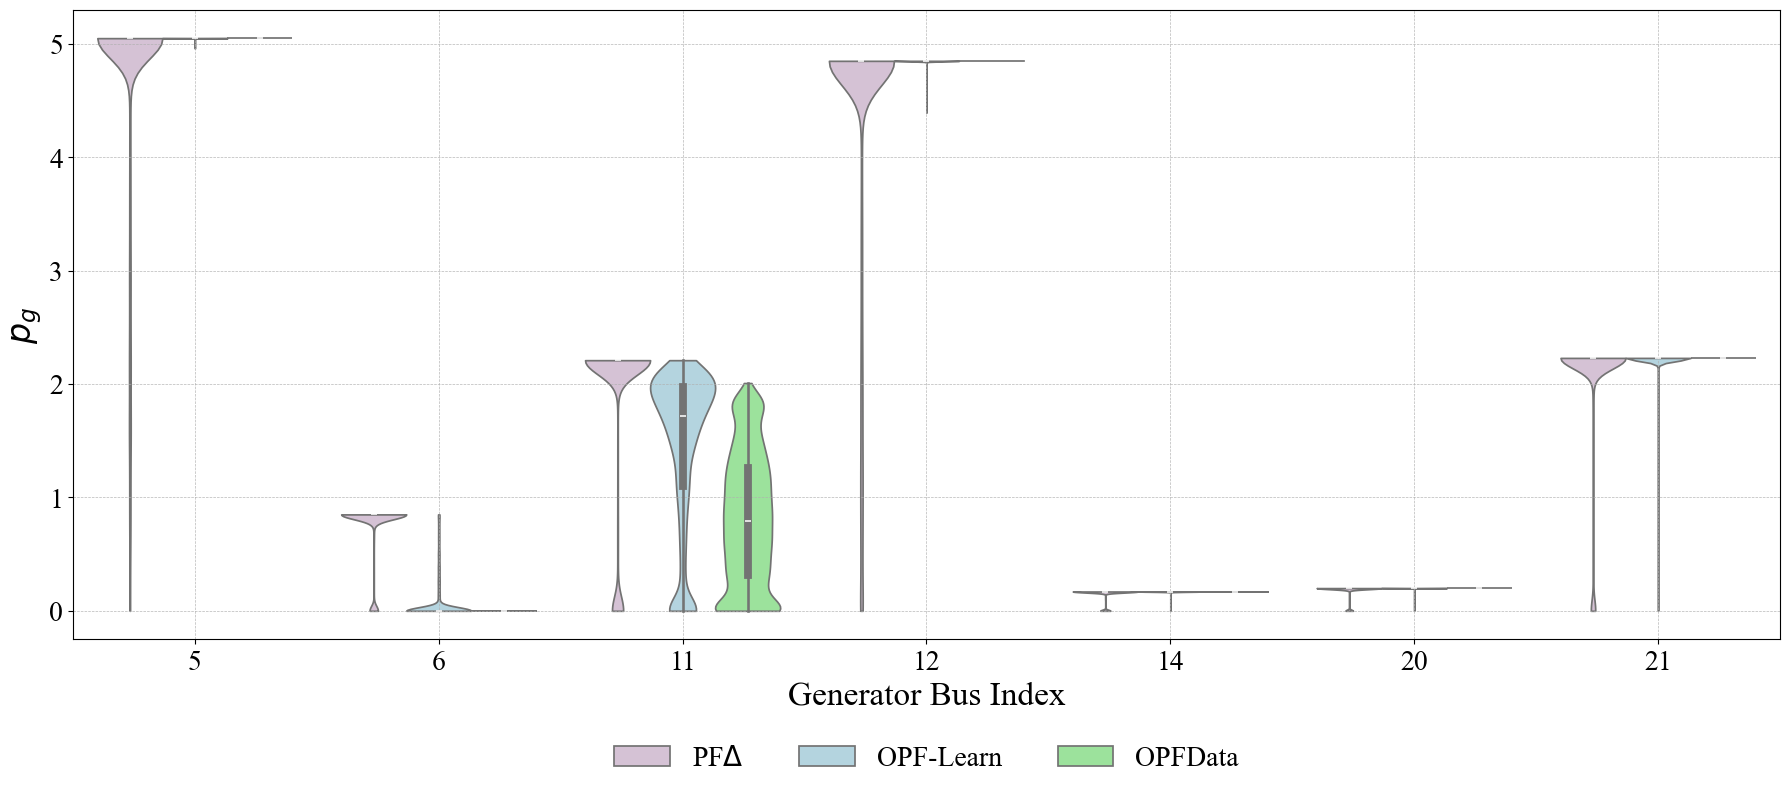

/var/folders/xd/y24vj_hj32x3352849rr9nl80000gn/T/ipykernel_17323/1406424275.py:50: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


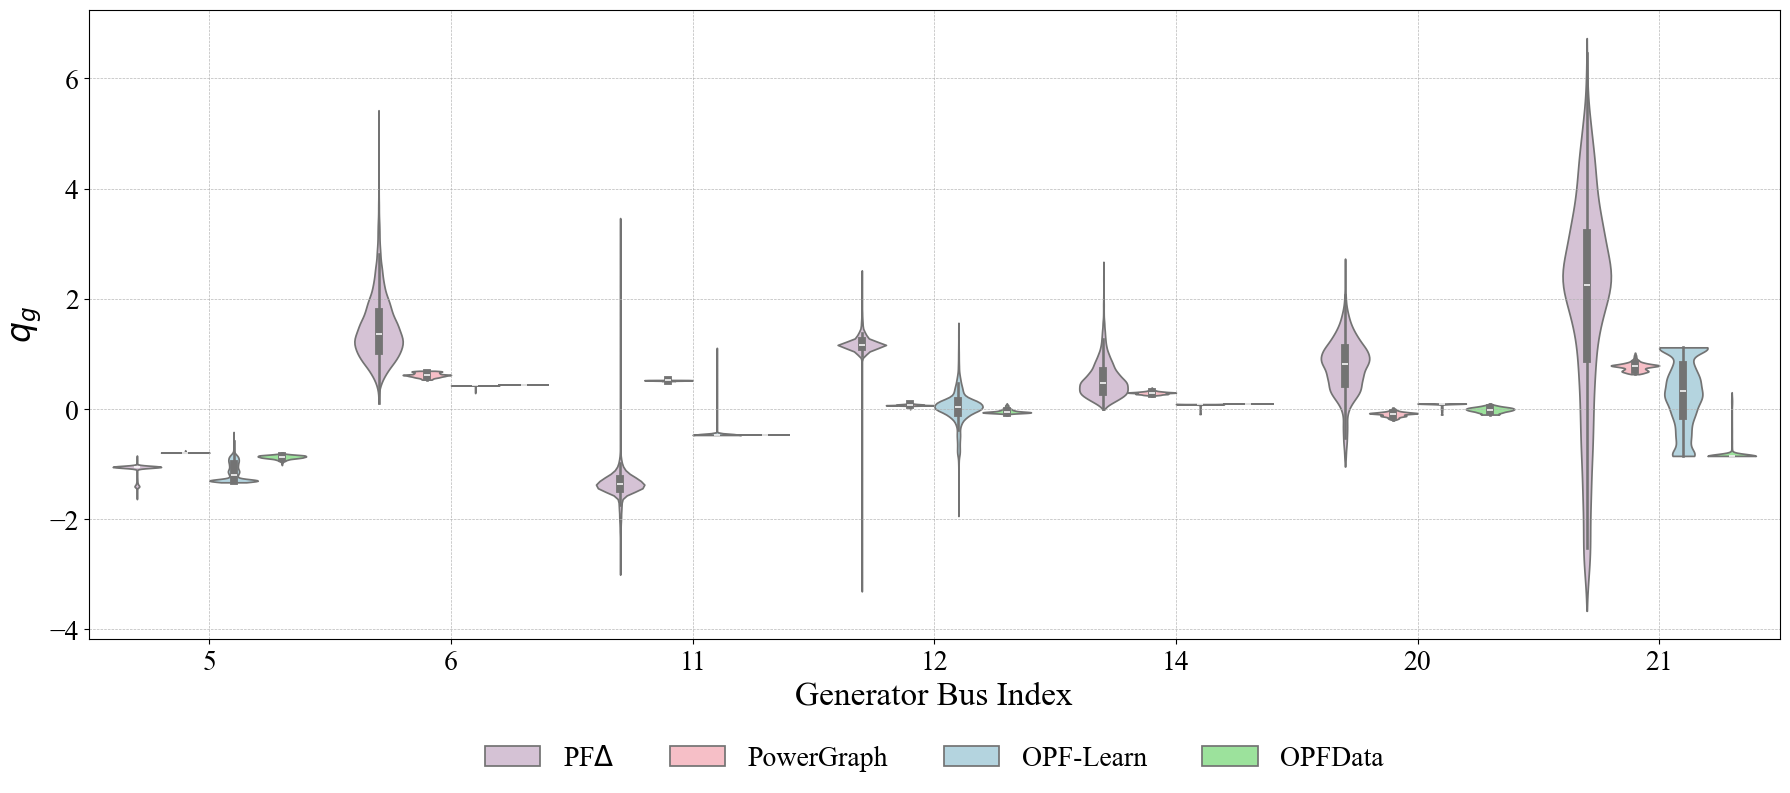

/var/folders/xd/y24vj_hj32x3352849rr9nl80000gn/T/ipykernel_17323/1406424275.py:50: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


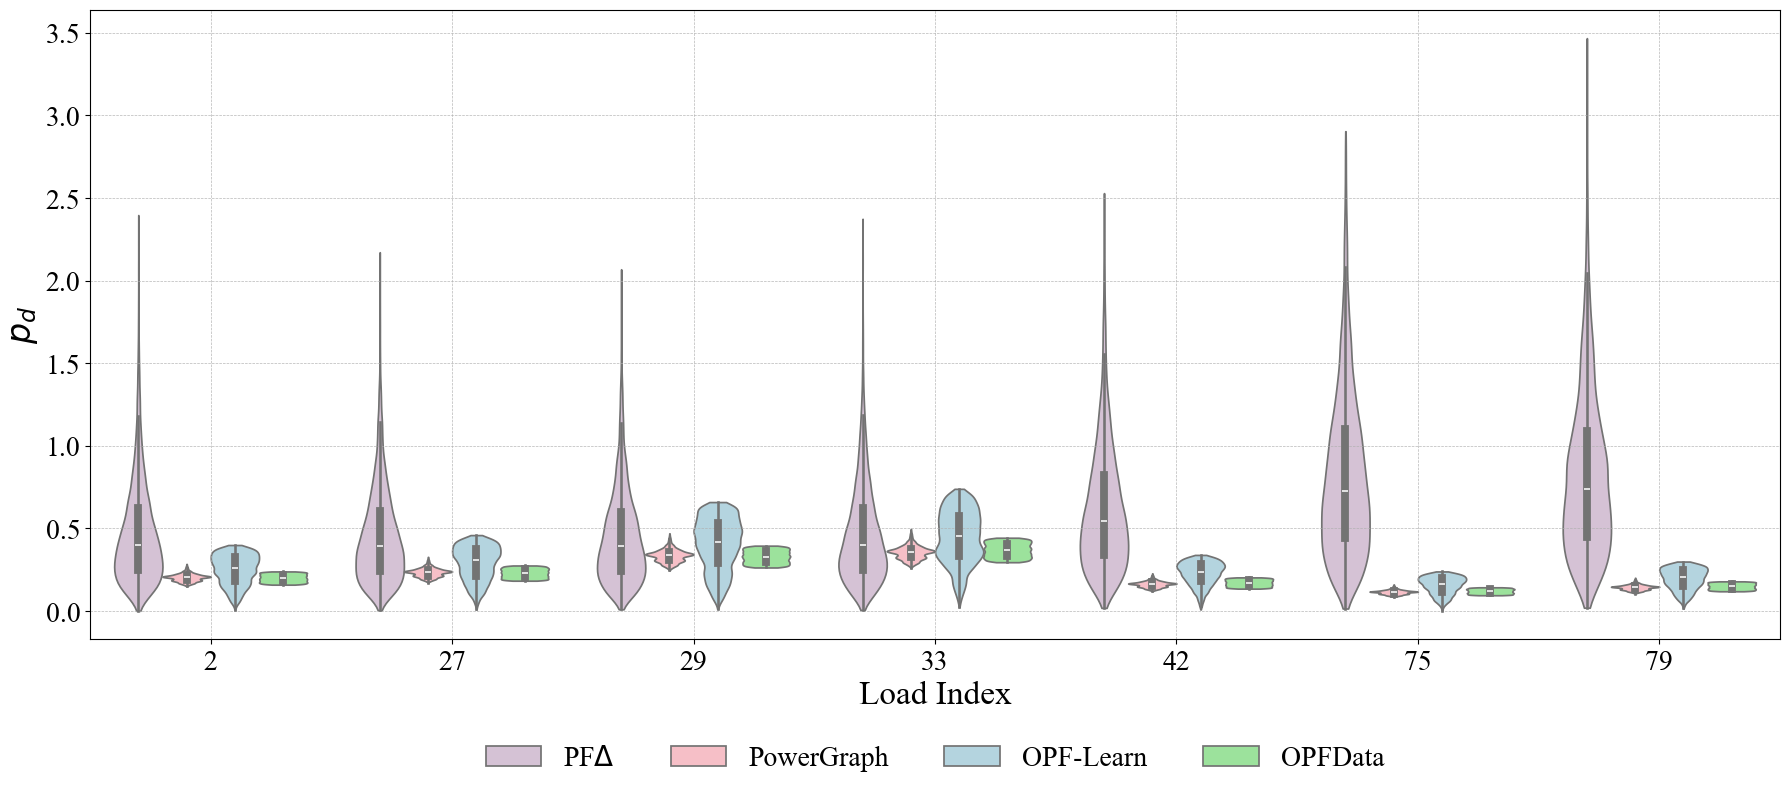

/var/folders/xd/y24vj_hj32x3352849rr9nl80000gn/T/ipykernel_17323/1406424275.py:50: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


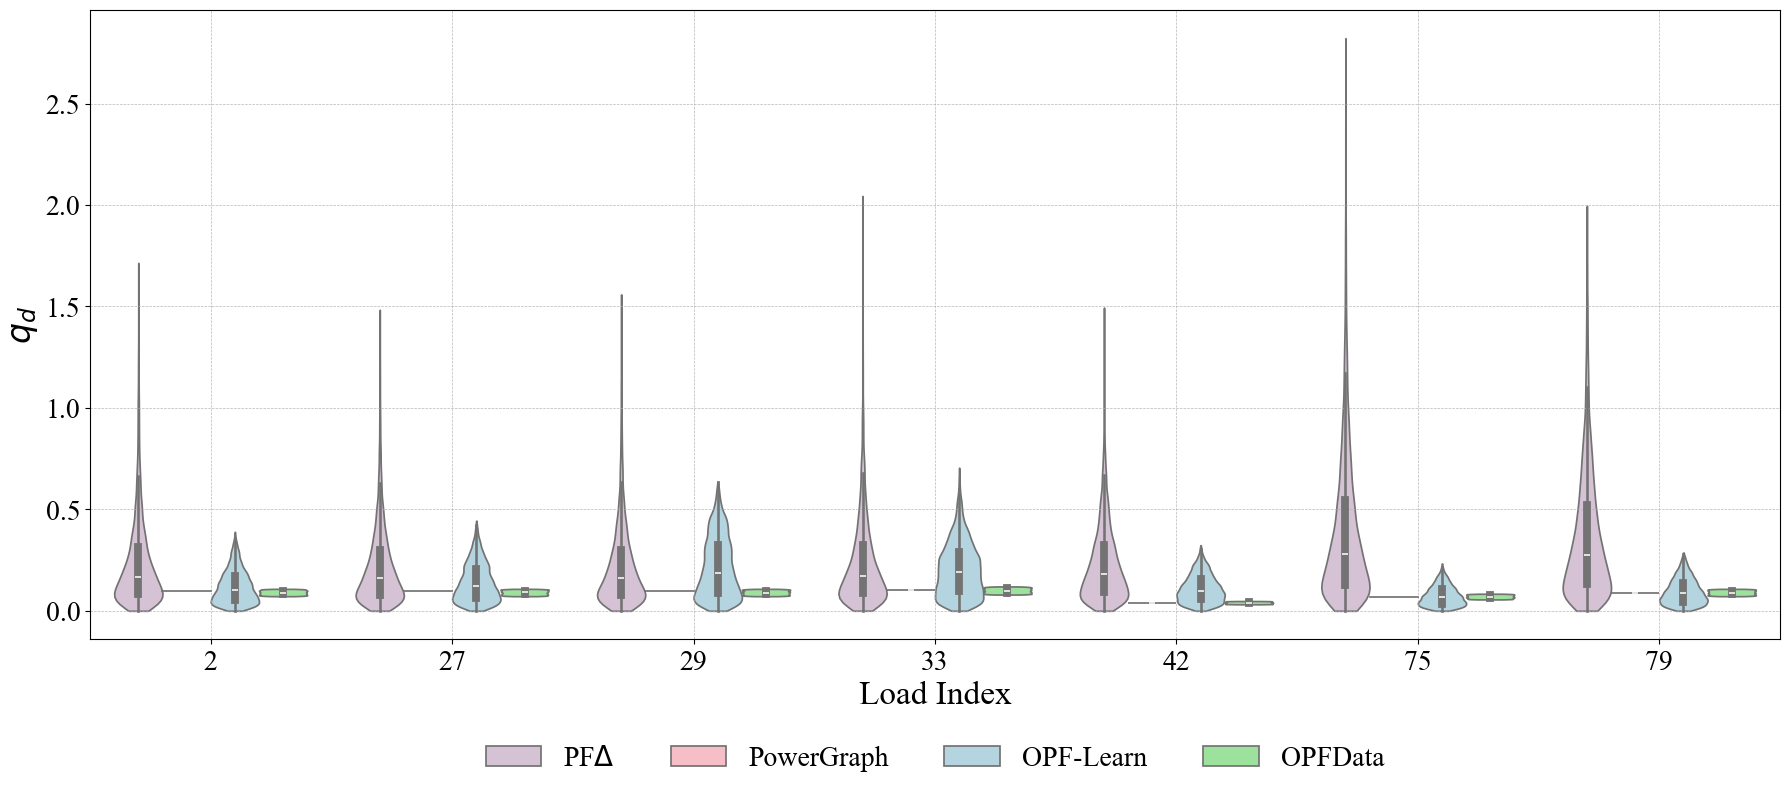

/var/folders/xd/y24vj_hj32x3352849rr9nl80000gn/T/ipykernel_17323/1406424275.py:50: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


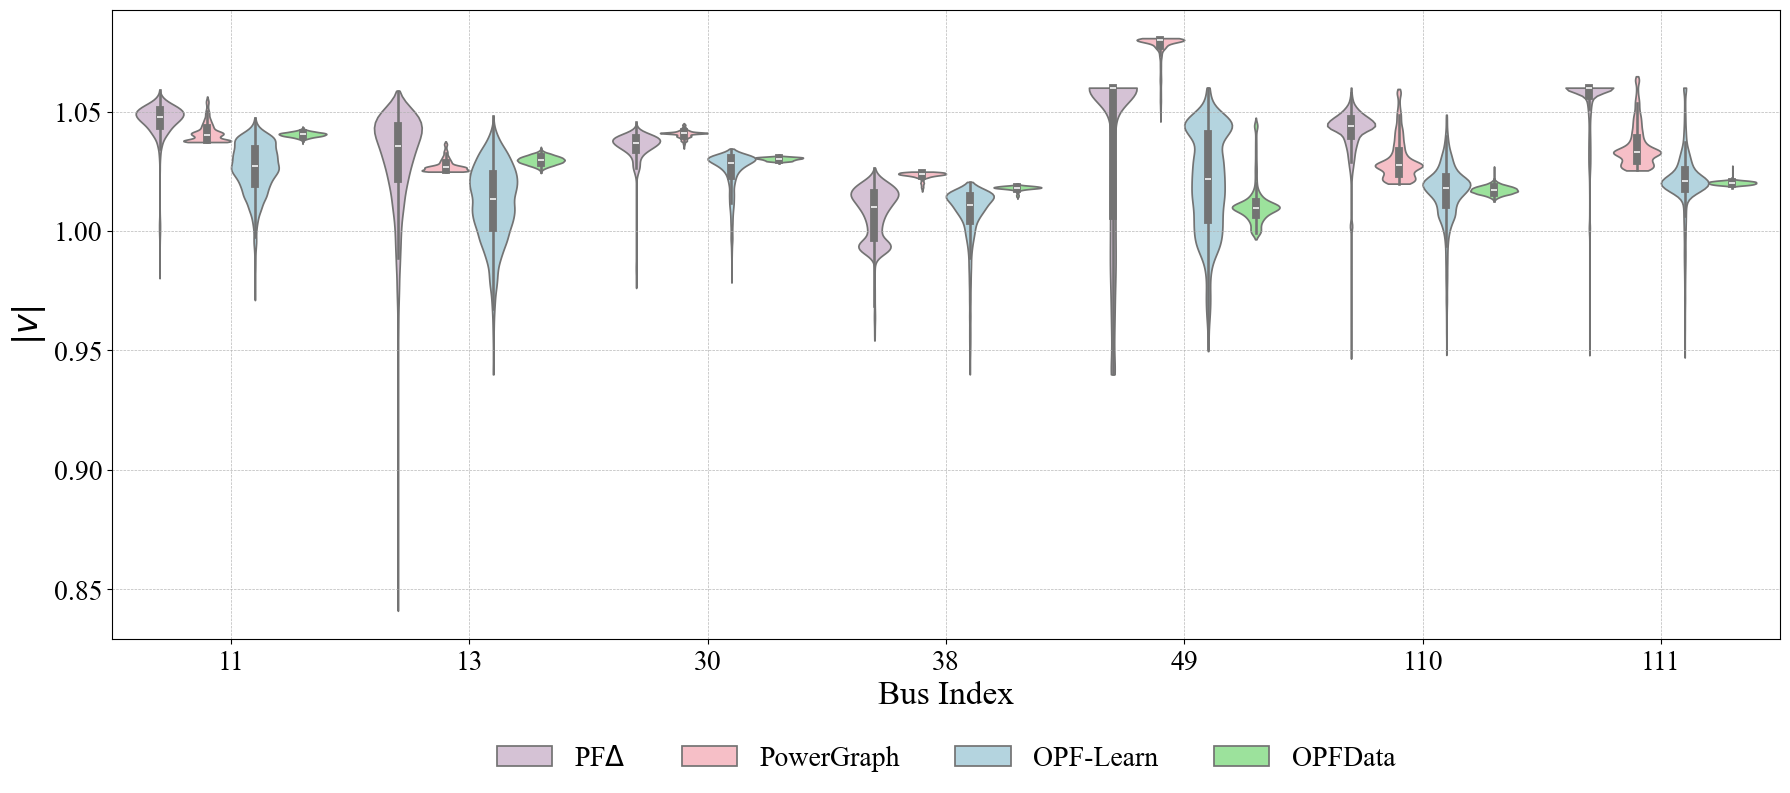

/var/folders/xd/y24vj_hj32x3352849rr9nl80000gn/T/ipykernel_17323/1406424275.py:50: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


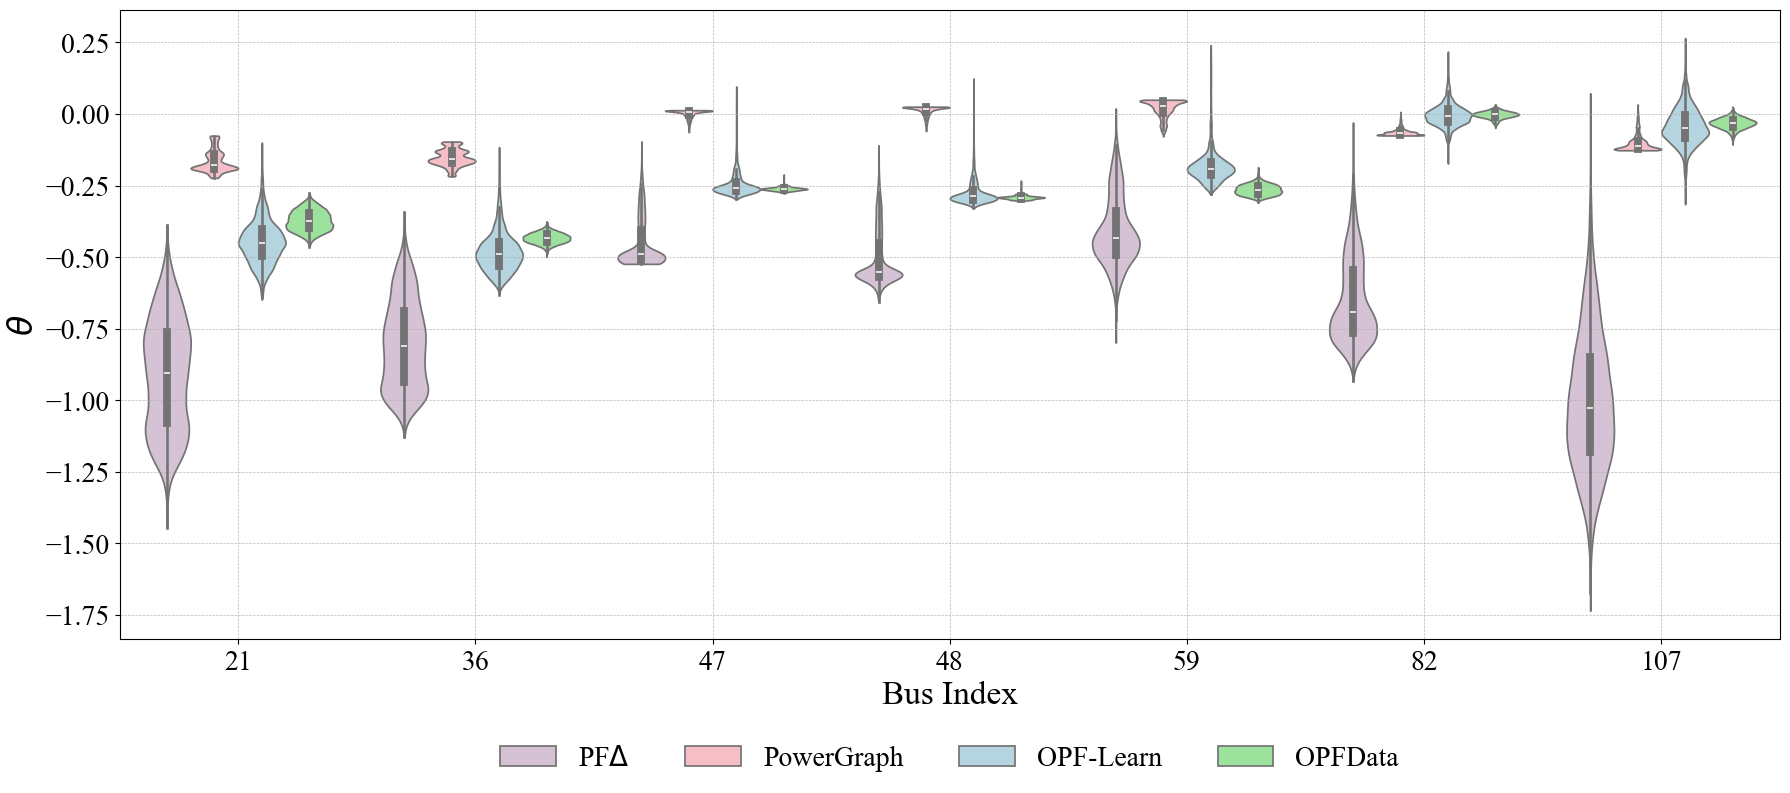

In [48]:
colors = ["#D8BFD8", "#FFB6C1", "#ADD8E6", "#90EE90"]
group_labels = [r'PF$\Delta$', "PowerGraph", "OPF-Learn", "OPFData"]
group_data = [pfdelta, powergraph, opflearn, opfdata]
x_ticks = 7

gen_buses_to_plot = [4, 5, 10, 11, 13, 19, 20] # slack is index 29
loads_to_plot = [28, 78, 1, 26, 74, 41, 32]

vars_to_plot = {
    "pg": sorted(gen_buses_to_plot) if x_ticks < num_gens else list(range(num_gens)),
    "qg": sorted(gen_buses_to_plot) if x_ticks < num_gens else list(range(num_gens)), 
    "pd": sorted(loads_to_plot) if x_ticks < num_loads else list(range(num_loads)),
    "qd": sorted(loads_to_plot) if x_ticks < num_loads else list(range(num_loads)),
    "vm": sorted(random.sample(range(num_buses), x_ticks)),
    "va": sorted(random.sample(range(num_buses), x_ticks))
}

var_labels = {
    "pg": r'$p_g$',
    "qg": r'$q_g$',
    "pd": r'$p_d$',
    "qd": r'$q_d$',
    "vm": r'$|v|$',
    "va": r'$\theta$'
}

output_dir_violin = "violin_plots"

for var, indices in vars_to_plot.items():
    records = []

    # Determine dataset indices to use
    if var == "pg":
        dataset_range = [0, 2, 3]  # exclude index 1 (PowerGraph)
    else:
        dataset_range = range(4)

    for idx in indices:
        for j in dataset_range:
            for val in group_data[j][var][:, idx]:
                records.append({
                    'Index': f"{idx+1}",  # index label for x-axis
                    'Value': val.item(),
                    'Dataset': group_labels[j],
                })

    df = pandas.DataFrame(records)

    plt.figure(figsize=(18, 8))
    sns.violinplot(
        data=df,
        x='Index',
        y='Value',
        hue='Dataset',
        palette=[colors[j] for j in dataset_range],  # match color subset
        cut=0,
        scale='width',
        split=False,
        inner='box'
    )

    plt.ylabel(var_labels[var])
    if var in ["pg", "qg"]:
        x_label = "Generator Bus Index"
    elif var in ["pd", "qd"]:
        x_label = "Load Index"
    elif var in ["vm", "va"]:
        x_label = "Bus Index"
    else:
        x_label = ""

    plt.xlabel(x_label)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.9)
    plt.legend(
        loc='lower center',
        bbox_to_anchor=(0.5, -0.25),
        ncol=len(dataset_range),
        frameon=False
    )   
    plt.tight_layout()

    save_path = os.path.join(output_dir_violin, var + "_violin_plot.svg")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


# Box Plots

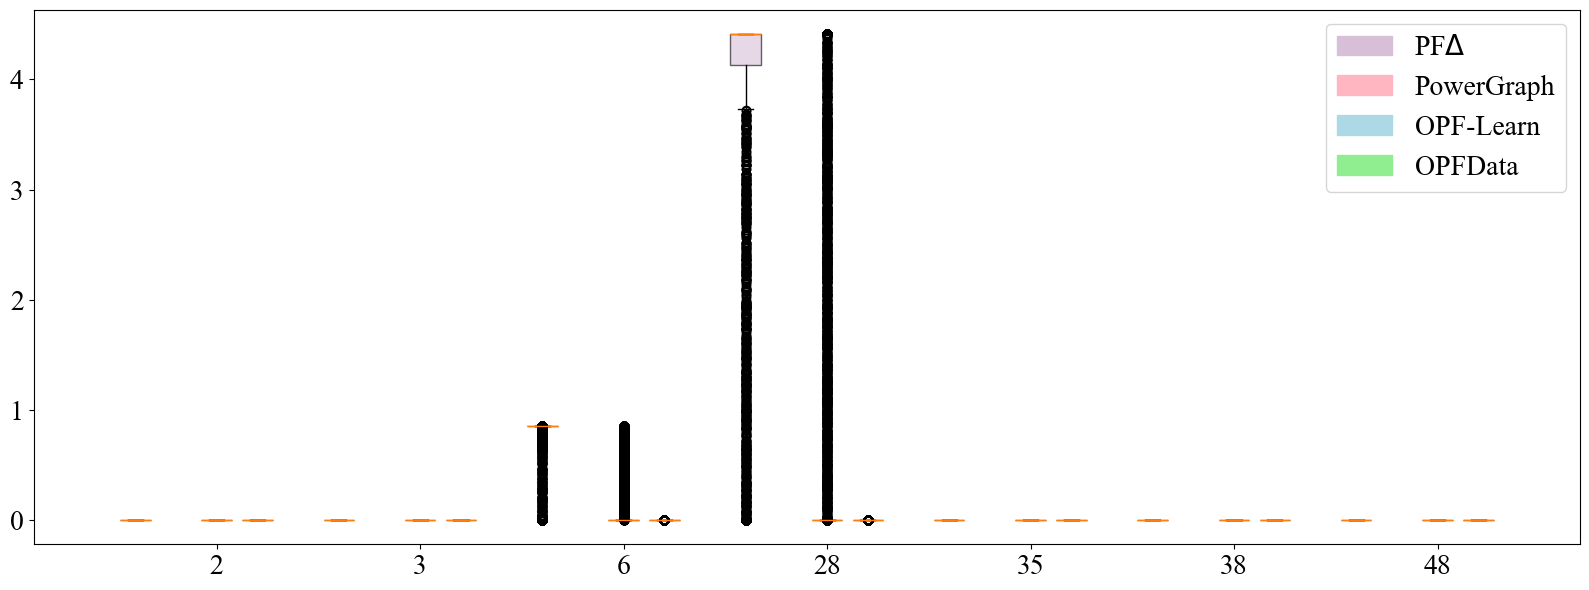

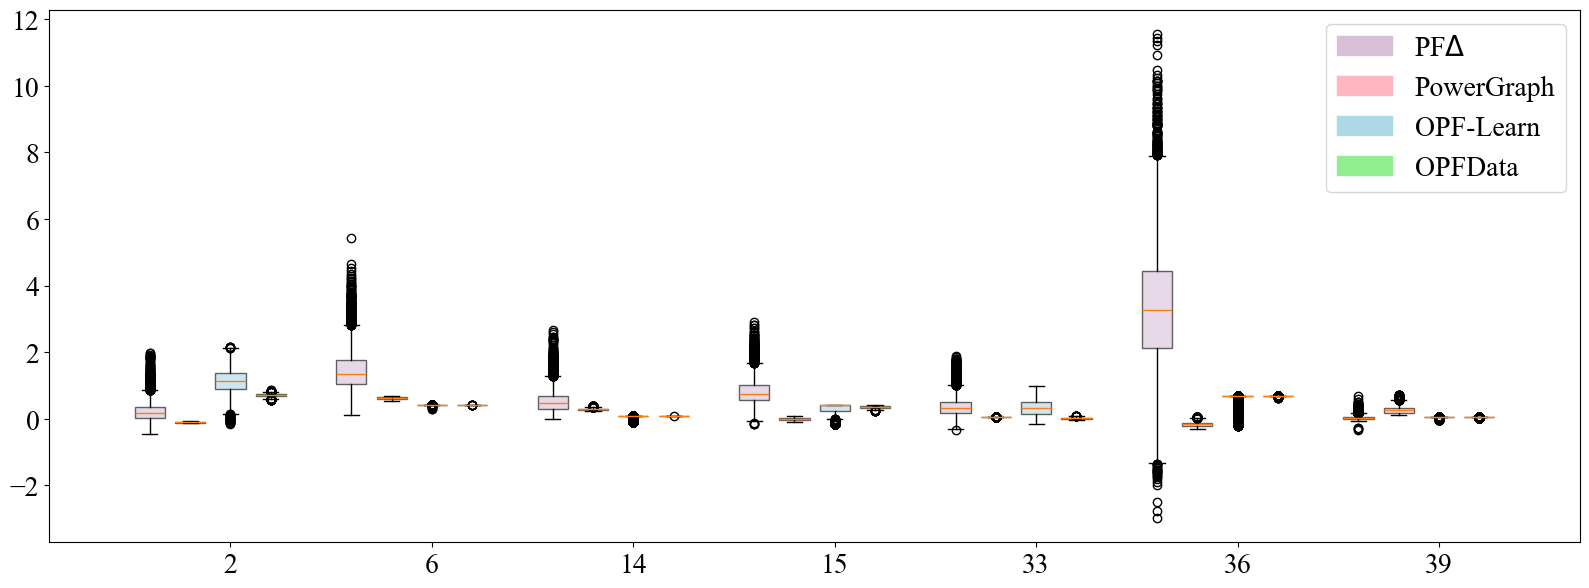

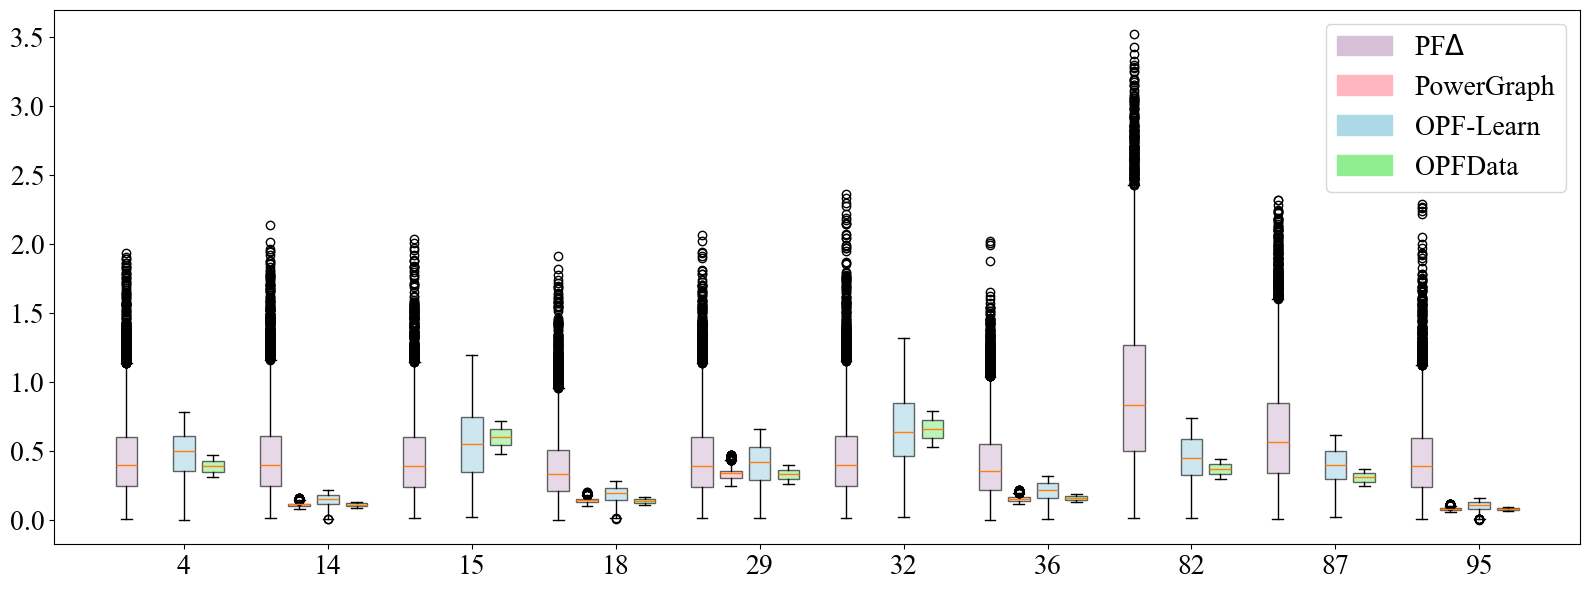

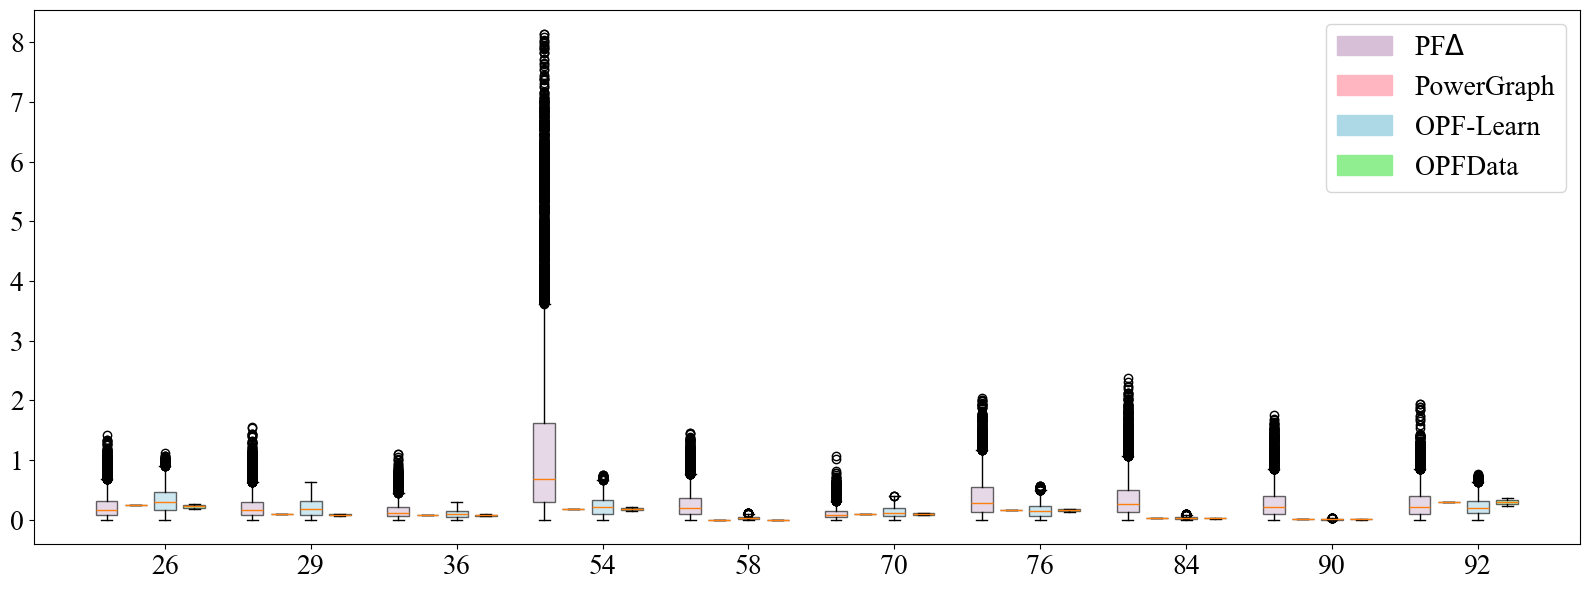

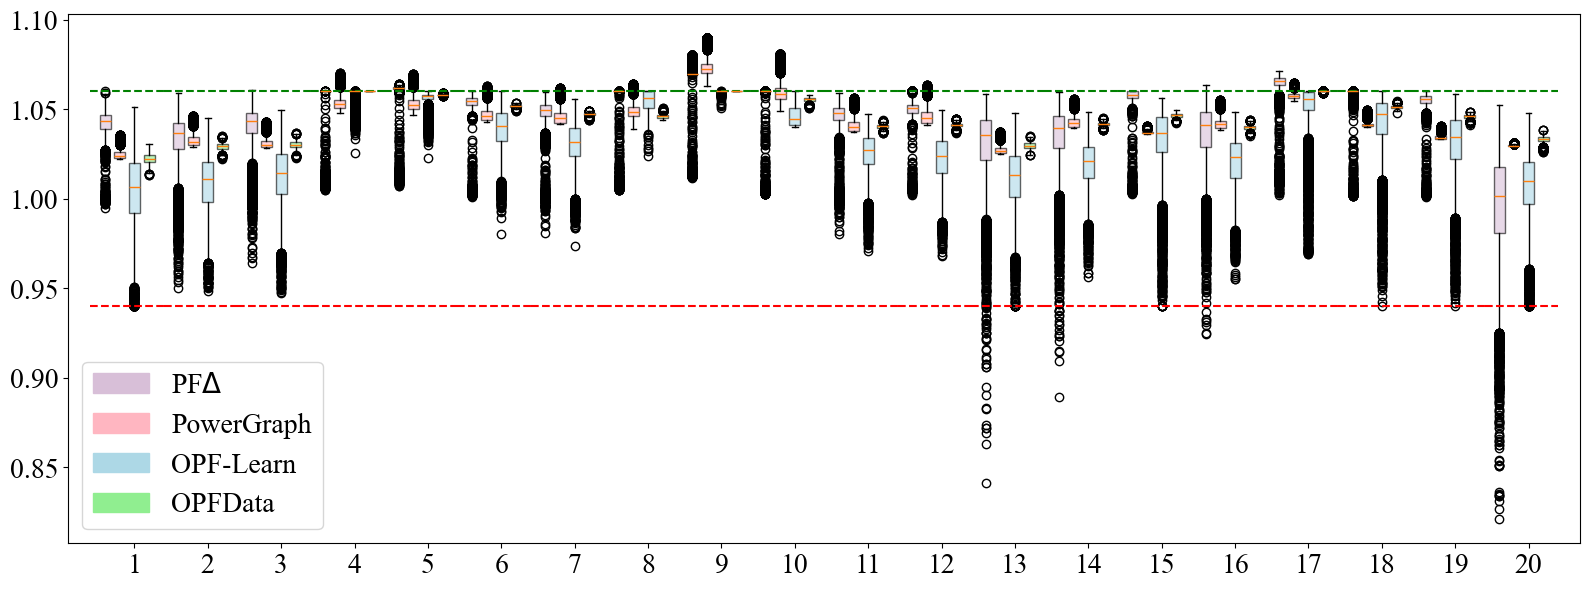

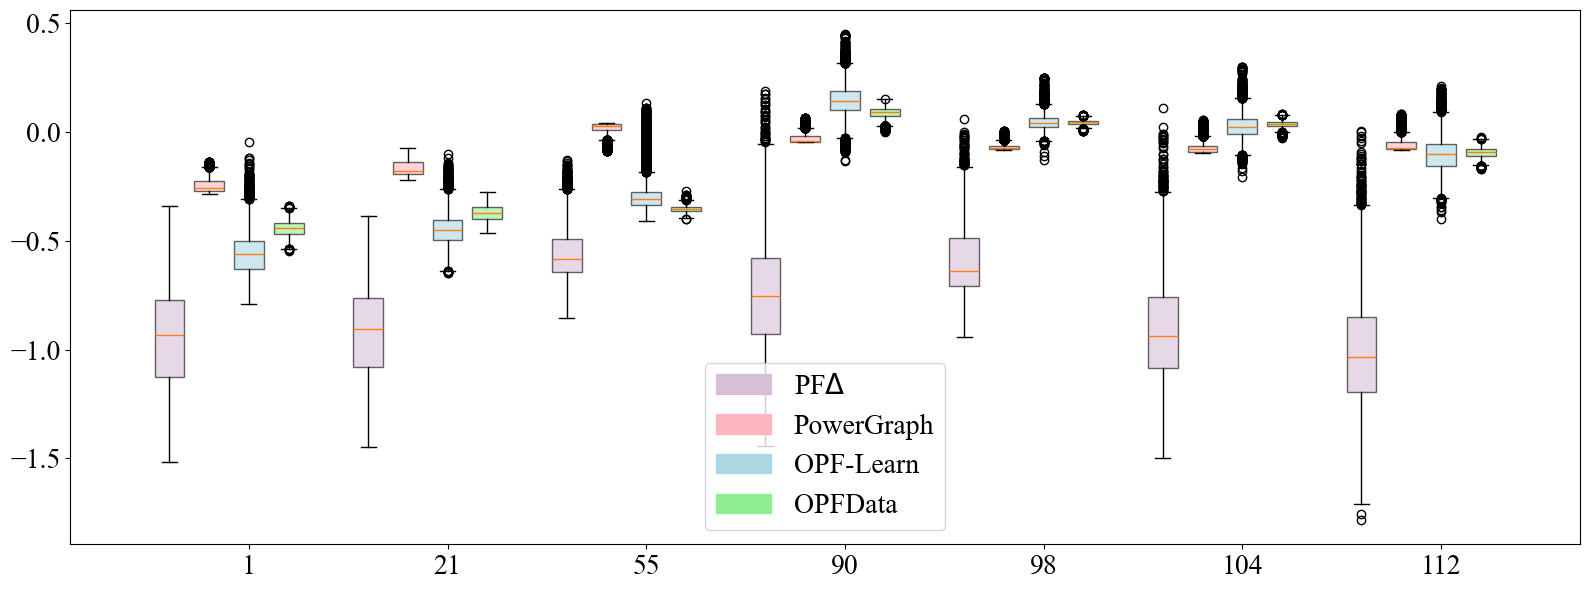

In [49]:
random.seed(42)
pd_indices = sorted(random.sample(range(num_loads), 10))

vars_to_plot = {
    "pg": sorted(random.sample(range(num_gens), x_ticks)) if x_ticks < num_gens else list(range(num_gens)),
    "qg": sorted(random.sample(range(num_gens), x_ticks)) if x_ticks < num_gens else list(range(num_gens)),
    "pd": sorted(pd_indices) if x_ticks < num_loads else list(range(num_loads)),
    "qd": sorted(random.sample(range(num_loads), 10)) if x_ticks < num_loads else list(range(num_loads)),
    "vm": sorted(range(0, 20)),
    "va": sorted(random.sample(range(num_buses), x_ticks))
}

colors = ["#D8BFD8", "#FFB6C1", "#ADD8E6", "#90EE90"]
group_labels = [r'PF$\Delta$', "PowerGraph", "OPF-Learn", "OPFData"]
group_data = [pfdelta, powergraph, opflearn, opfdata]

for var, indices in vars_to_plot.items():
    data = []
    for i in indices:
        for dataset in group_data:
            data.append(dataset[var][:, i].numpy())

    positions = np.array([np.arange(len(indices)) + i * 0.2 for i in range(len(group_data))]).T.flatten()

    fig, ax = plt.subplots(figsize=(16, 6))
    boxplot = ax.boxplot(data, positions=positions, widths=0.15, showfliers=True, patch_artist=True)

    for i, patch in enumerate(boxplot['boxes']):
        patch.set_facecolor(colors[i % len(colors)])
        patch.set_alpha(0.6)

    xtick_positions = np.arange(len(indices)) + 0.4
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels([f"{i+1}" for i in indices])

    legend_patches = [mpatches.Patch(color=colors[i], label=group_labels[i]) for i in range(len(group_labels))]
    ax.legend(handles=legend_patches, loc="best")

    # Add Vmin/Vmax lines for voltage magnitude
    if var == "vm":
        for idx, bus_idx in enumerate(indices):
            vmin = vmin_array[bus_idx]
            vmax = vmax_array[bus_idx]
            ax.hlines(vmin, idx - 0.2, idx + 0.8, colors='red', linestyles='--', label='Vmin' if idx == 0 else "")
            ax.hlines(vmax, idx - 0.2, idx + 0.8, colors='green', linestyles='--', label='Vmax' if idx == 0 else "")

    # Add Pmin/Pmax for PV voltages (this only makes sense for buses with just one generators.)

    plt.tight_layout()
    plt.show()


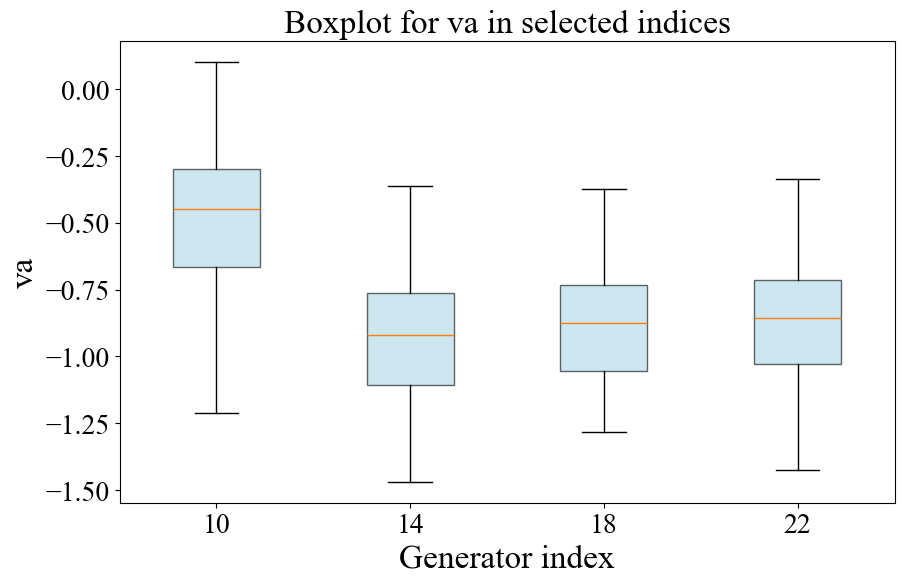

In [50]:
# Cell to look at weird stuff

# Example setup
var = "va"
dataset = pfdelta  # Choose between available datasets
num_buses = dataset["va"].shape[1]  # adjust depending on your case
indices = sorted(random.sample(range(num_gens), 4))  # pick 4 random generators

# Collect the data
data = [dataset[var][:, i].numpy() for i in indices]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
boxplot = ax.boxplot(data, patch_artist=True, showfliers=False)

# Styling (optional)
for patch in boxplot['boxes']:
    patch.set_facecolor("#ADD8E6")  # light blue
    patch.set_alpha(0.6)

# Set x-ticks
ax.set_xticks(np.arange(1, len(indices) + 1))
ax.set_xticklabels([f"{i+1}" for i in indices])

ax.set_title(f"Boxplot for {var} in selected indices")
ax.set_ylabel(var)
ax.set_xlabel("Generator index")

plt.show()

/var/folders/xd/y24vj_hj32x3352849rr9nl80000gn/T/ipykernel_17323/2682391847.py:30: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/var/folders/xd/y24vj_hj32x3352849rr9nl80000gn/T/ipykernel_17323/2682391847.py:30: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(
/var/folders/xd/y24vj_hj32x3352849rr9nl80000gn/T/ipykernel_17323/2682391847.py:30: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/var/folders/xd/y24vj_hj32x3352849rr9nl80000gn/T/ipykernel_17323/2682391847.py:30: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but 

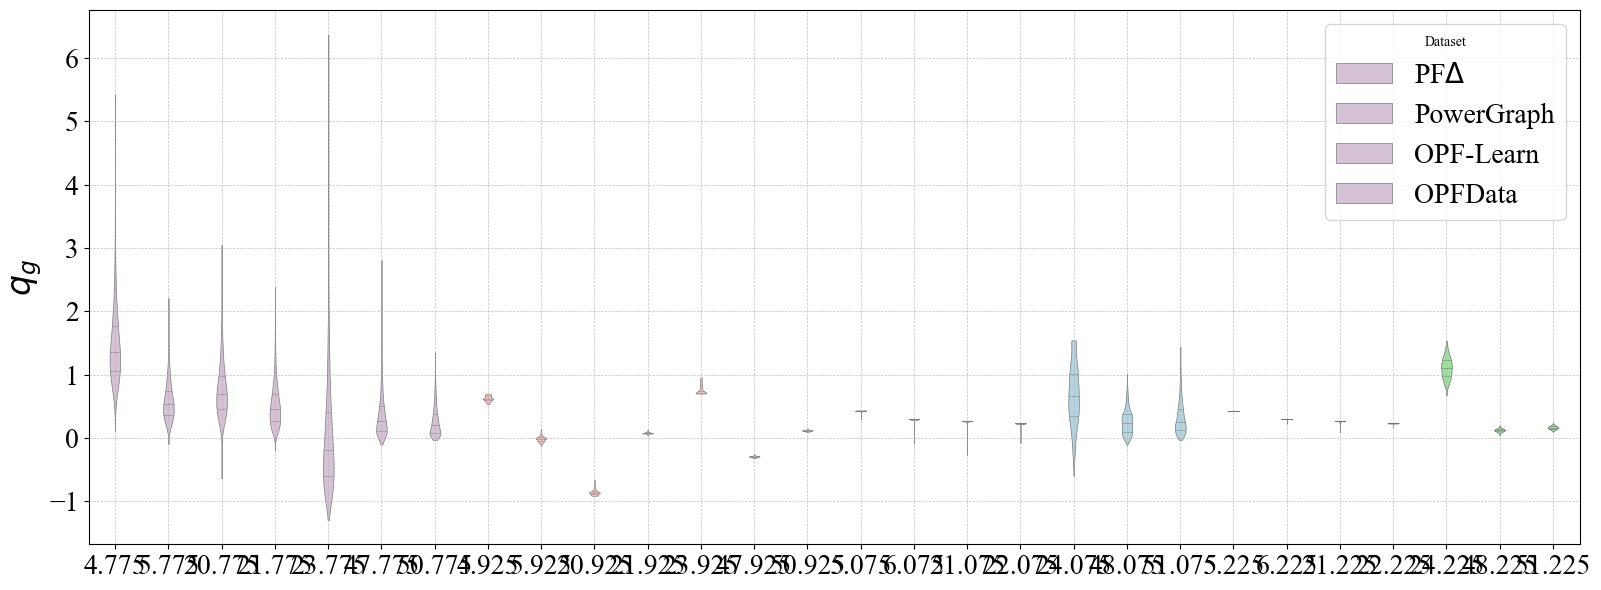

In [51]:
import matplotlib.pyplot as plt

# Sample setup (replacing with your real data logic)
colors = ["#D8BFD8", "#FFB6C1", "#ADD8E6", "#90EE90"]
group_labels = [r'PF$\Delta$', "PowerGraph", "OPF-Learn", "OPFData"]
data_groups = [pfdelta, powergraph, opflearn, opfdata]  # Each [var][sample, index]

var = 'qg'
indices = sorted(random.sample(range(num_gens), x_ticks))
records = []

for i, label in enumerate(group_labels):
    for idx in indices:
        for val in data_groups[i][var][:, idx]:
            records.append({
                'Bus': idx + 1,
                'Value': val.item(),
                'Dataset': label,
                'OffsetBus': idx + (i - 1.5) * 0.15,
                'Group': i  # for shifting later
            })

df = pandas.DataFrame(records)

# Plot setup
fig, ax = plt.subplots(figsize=(16, 6))
width = 0.8 / len(group_labels)  # To fit all half-violins per index

for i, label in enumerate(group_labels):
    sns.violinplot(
        data=df[df['Dataset'] == label],
        x='OffsetBus',
        y='Value',
        color=colors[i],
        cut=0,
        bw=0.2,
        scale='width',
        inner='quart',
        linewidth=0.5,
        ax=ax,
        width=width,
        dodge=False
    )

# Now shift each group's violin manually
for i, coll in enumerate(ax.collections):
    if i % 2 == 0:  # Fill (not line) collections
        offset = (i // 2 % len(group_labels)) - (len(group_labels)-1)/2
        transform = plt.matplotlib.transforms.Affine2D().translate(offset * width, 0)
        coll.set_transform(coll.get_transform() + transform)

ax.set_xlabel("")
ax.set_ylabel(var_labels[var])
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.8)
ax.legend(handles=ax.collections[::2][:len(group_labels)], labels=group_labels, title='Dataset')
plt.tight_layout()
plt.show()


/var/folders/xd/y24vj_hj32x3352849rr9nl80000gn/T/ipykernel_17323/1542219977.py:27: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x='bus', y='value', hue='group', split=True,


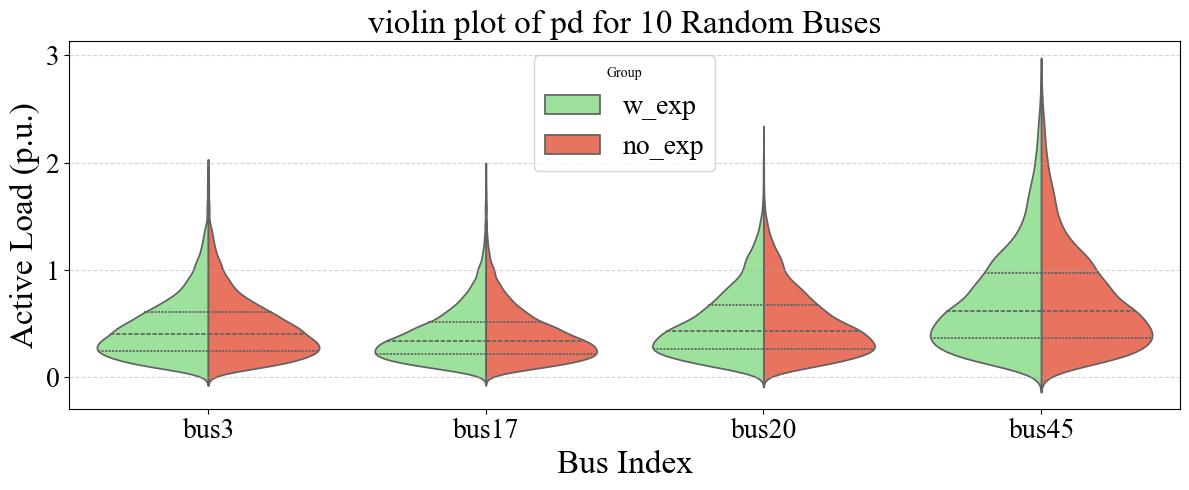

In [52]:
# Extract data
var = 'pd'
pd1 = pfdelta[ var]
pd2 = pfdelta[var]
pd1 = pd1.cpu().numpy() if isinstance(pd1, torch.Tensor) else pd1
pd2 = pd2.cpu().numpy() if isinstance(pd2, torch.Tensor) else pd2

n_samples, n_loads = pd1.shape

# Randomly select 10 load buses
np.random.seed(10)
selected_buses = np.random.choice(num_gens, size=4, replace=False)
selected_buses = sorted(selected_buses)

# Stack the data
pd1_selected = pd1[:, selected_buses].flatten()
pd2_selected = pd2[:, selected_buses].flatten()

df = pandas.DataFrame({
    'value': np.concatenate([pd1_selected, pd2_selected]),
    'bus': np.tile([f'bus{i}' for i in selected_buses], 2 * n_samples),
    'group': ['w_exp'] * (n_samples * len(selected_buses)) + ['no_exp'] * (n_samples * len(selected_buses))
})

# Plot
plt.figure(figsize=(12, 5))
sns.violinplot(data=df, x='bus', y='value', hue='group', split=True,
               inner='quartile', scale='width', palette={"w_exp": "#90EE90", "no_exp": "#FF6347"})

plt.title(f"violin plot of {var} for 10 Random Buses")
plt.ylabel("Active Load (p.u.)")
plt.xlabel("Bus Index")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(title='Group')
plt.show()


/var/folders/xd/y24vj_hj32x3352849rr9nl80000gn/T/ipykernel_17323/3141928138.py:21: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df_vm, x='bus', y='value', scale='width', inner='quartile')


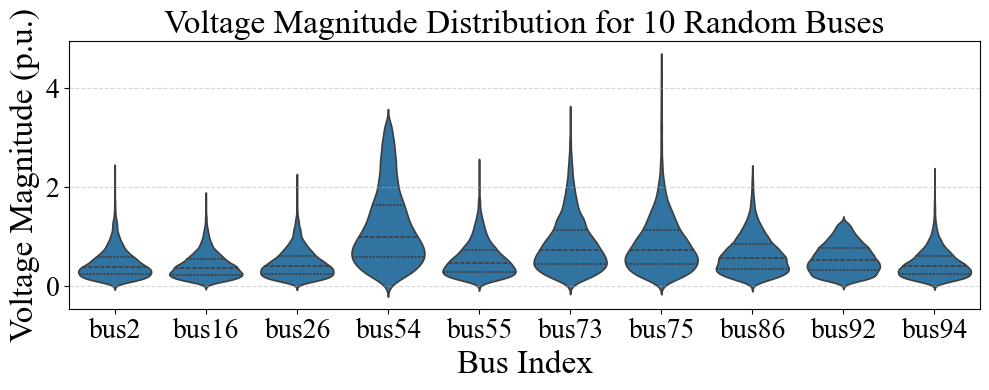

In [53]:
vm = pfdelta['pd']  # shape: [n_samples, n_buses]
vm = vm.cpu().numpy() if isinstance(vm, torch.Tensor) else vm

n_samples, n_buses = vm.shape

# Randomly select 10 unique bus indices
np.random.seed(0)  # for reproducibility (optional)
selected_buses = np.random.choice(n_buses, size=10, replace=False)
selected_buses = sorted(selected_buses)  # optional, for nicer plotting

# Extract the corresponding columns
vm_selected = vm[:, selected_buses]

# Build long-form DataFrame
df_vm = pandas.DataFrame({
    'value': vm_selected.flatten(),
    'bus': [f'bus{i}' for i in selected_buses] * n_samples
})

plt.figure(figsize=(10, 4))
sns.violinplot(data=df_vm, x='bus', y='value', scale='width', inner='quartile')
plt.title('Voltage Magnitude Distribution for 10 Random Buses')
plt.ylabel('Voltage Magnitude (p.u.)')
plt.xlabel('Bus Index')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()